In [1]:
import nfl_data_py as nfl
import pandas as pd
import os
import urllib.request
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

In [3]:
#filtering 2023 player data
df_2023 = nfl.import_weekly_data([2023])
columns_to_keep  = ['player_id', 'player_name', 'position', 'position_group', 'season', 'week', 
                   'passing_yards', 'passing_tds', 'interceptions', 'passing_air_yards',
                   'passing_yards_after_catch', 'passing_first_downs', 'passing_epa',
                   'passing_2pt_conversions', 'carries', 'rushing_yards', 'rushing_tds', 
                   'rushing_fumbles_lost', 'rushing_first_downs', 'rushing_epa', 
                   'rushing_2pt_conversions', 'receiving_fumbles_lost', 'receiving_air_yards',
                   'receiving_yards_after_catch', 'receiving_first_downs', 'receiving_epa', 
                   'receiving_2pt_conversions', 'racr', 'target_share', 'air_yards_share',
                   'fantasy_points_ppr', 'receptions', 'targets', 'receiving_yards', 
                   'receiving_tds']

filtered1_df_2023 = df_2023[columns_to_keep]

Downcasting floats.


In [5]:
df_2022 = nfl.import_weekly_data([2022])
filtered_df_2022 = df_2022[columns_to_keep]
average_fantasy_points_df_2022 = filtered_df_2022.groupby(['player_id', 'player_name', 'position', 'position_group'], as_index=False)['fantasy_points_ppr'].mean()
average_fantasy_points_df_2022.rename(columns={'fantasy_points_ppr': 'avg_fantasy_points_ppr'}, inplace=True)

Downcasting floats.


In [7]:
#merging the dataframes to put the 2022 averages in with the 2023 week by week data
average_fantasy_points_df_2022 = filtered_df_2022.groupby(['player_id'], as_index=False)['fantasy_points_ppr'].mean()
average_fantasy_points_df_2022.rename(columns={'fantasy_points_ppr': 'avg_fantasy_points_ppr'}, inplace=True)
merged_df = pd.merge(filtered1_df_2023, average_fantasy_points_df_2022, on='player_id', how='left')
merged_df['avg_fantasy_points_ppr'].fillna(0, inplace=True)
#print(merged_df)


In [9]:
merged_df['net_points'] = merged_df['avg_fantasy_points_ppr'] - merged_df['fantasy_points_ppr']
#remove all rows where 'avg_fantasy_points_ppr' is equal to 0 (takes out rookies in 2023, injuries, etc.)
merged_df = merged_df[merged_df['avg_fantasy_points_ppr'] != 0]
#print(merged_df[['player_id', 'player_name', 'position', 'week', 'fantasy_points_ppr', 'avg_fantasy_points_ppr', 'net_points']])


In [11]:
merged_df['percent_change'] = ((merged_df['fantasy_points_ppr'] - merged_df['avg_fantasy_points_ppr']) / merged_df['avg_fantasy_points_ppr']) * 100

merged_df = merged_df[merged_df['avg_fantasy_points_ppr'] != 0]

print(merged_df[['player_id', 'player_name', 'position', 'week', 'fantasy_points_ppr', 'avg_fantasy_points_ppr', 'percent_change']].head())


    player_id player_name position  week  fantasy_points_ppr  \
0  00-0023459   A.Rodgers       QB     1                 0.0   
1  00-0024243     M.Lewis       TE     4                 1.8   
2  00-0024243     M.Lewis       TE     7                 2.6   
3  00-0024243     M.Lewis       TE    11                 0.0   
4  00-0024243     M.Lewis       TE    14                 1.4   

   avg_fantasy_points_ppr  percent_change  
0               14.070588     -100.000000  
1                4.433333      -59.398495  
2                4.433333      -41.353386  
3                4.433333     -100.000000  
4                4.433333      -68.421051  


In [13]:
import pandas as pd
def find_players_with_streaks(min_weeks=3, max_weeks=17):
    streak_data = []

    for streak_length in range(min_weeks, max_weeks + 1):
        for player_id, player_data in merged_df.groupby('player_id'):
            player_name = player_data['player_name'].iloc[0]
            position = player_data['position'].iloc[0]
            avg_2022_points = player_data['avg_fantasy_points_ppr'].iloc[0]

            player_data = player_data.sort_values(by='week').reset_index(drop=True)

            player_data['rolling_avg'] = player_data['fantasy_points_ppr'].rolling(window=streak_length).mean()
            qualifying_streaks = player_data[player_data['rolling_avg'] > avg_2022_points * 1.33]

            if len(qualifying_streaks) >= streak_length:
                streak_data.append({
                    'player_id': player_id,
                    'player_name': player_name,
                    'position': position,
                    'streak_length': streak_length,
                    'weeks': list(qualifying_streaks['week']),
                    'rolling_avg': qualifying_streaks['rolling_avg'].iloc[-1]
                })

    return pd.DataFrame(streak_data)

streaks_df = find_players_with_streaks()
print(streaks_df)


      player_id player_name position  streak_length  \
0    00-0026158    J.Flacco       QB              3   
1    00-0026498  M.Stafford       QB              3   
2    00-0028118    T.Taylor       QB              3   
3    00-0029892  K.Juszczyk       FB              3   
4    00-0030035   A.Thielen       WR              3   
..          ...         ...      ...            ...   
400  00-0034855  B.Mayfield       QB             10   
401  00-0036264      J.Love       QB             10   
402  00-0037248      J.Cook       RB             10   
403  00-0037256     R.White       RB             10   
404  00-0037834     B.Purdy       QB             10   

                                        weeks  rolling_avg  
0                            [15, 16, 17, 19]    20.353333  
1                    [13, 14, 15, 16, 17, 19]    18.660000  
2                          [7, 8, 15, 17, 18]    15.286667  
3                                 [6, 15, 22]     5.400000  
4                          [3, 4, 

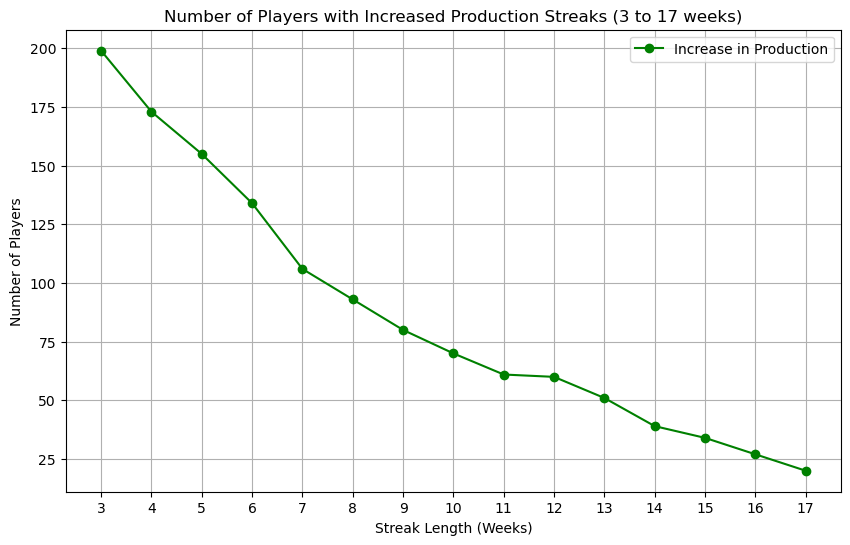

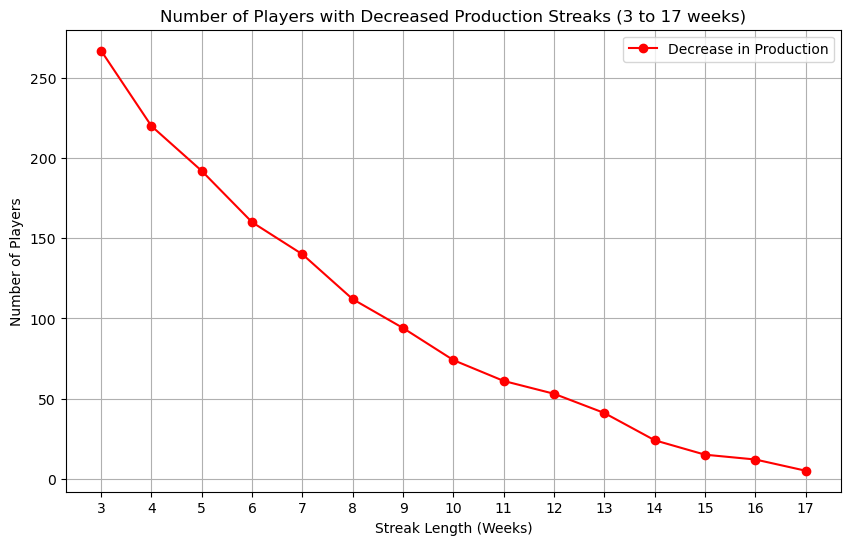

In [65]:
import matplotlib.pyplot as plt

def count_streaks_for_increase_and_decrease(merged_df, min_weeks=3, max_weeks=17):
    streak_counts_increase = []
    streak_counts_decrease = []
    
    player_ids = merged_df['player_id'].unique()

    for streak_length in range(min_weeks, max_weeks + 1):
        count_increase = 0
        count_decrease = 0

        for player_id in player_ids:
            player_data = merged_df[merged_df['player_id'] == player_id].sort_values('week')
            avg_fantasy_points_2022 = player_data['avg_fantasy_points_ppr'].iloc[0]

            player_data['rolling_avg'] = player_data['fantasy_points_ppr'].rolling(window=streak_length, min_periods=streak_length).mean()

            if player_data['rolling_avg'].isna().all():
                continue  

            if (player_data['rolling_avg'] > avg_fantasy_points_2022 * 1.33).any():
                count_increase += 1

            if (player_data['rolling_avg'] < avg_fantasy_points_2022 * 0.67).any():
                count_decrease += 1

        streak_counts_increase.append(count_increase)
        streak_counts_decrease.append(count_decrease)

    return streak_counts_increase, streak_counts_decrease

streak_counts_increase, streak_counts_decrease = count_streaks_for_increase_and_decrease(merged_df)

plt.figure(figsize=(10, 6))
plt.plot(range(3, 18), streak_counts_increase, marker='o', color='green', label='Increase in Production')
plt.title('Number of Players with Increased Production Streaks (3 to 17 weeks)')
plt.xlabel('Streak Length (Weeks)')
plt.ylabel('Number of Players')
plt.grid(True)
plt.xticks(range(3, 18))
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(3, 18), streak_counts_decrease, marker='o', color='red', label='Decrease in Production')
plt.title('Number of Players with Decreased Production Streaks (3 to 17 weeks)')
plt.xlabel('Streak Length (Weeks)')
plt.ylabel('Number of Players')
plt.grid(True)
plt.xticks(range(3, 18))
plt.legend()
plt.show()


/var/folders/4d/9v04gb7d0z75_dg3gtdvtnz40000gn/T/ipykernel_8642/4223939573.py:5: RuntimeWarning: invalid value encountered in log
  return 6.9 * np.log(avg_points) - .5
/var/folders/4d/9v04gb7d0z75_dg3gtdvtnz40000gn/T/ipykernel_8642/4223939573.py:5: RuntimeWarning: invalid value encountered in log
  return 6.9 * np.log(avg_points) - .5
/var/folders/4d/9v04gb7d0z75_dg3gtdvtnz40000gn/T/ipykernel_8642/4223939573.py:5: RuntimeWarning: invalid value encountered in log
  return 6.9 * np.log(avg_points) - .5
/var/folders/4d/9v04gb7d0z75_dg3gtdvtnz40000gn/T/ipykernel_8642/4223939573.py:5: RuntimeWarning: invalid value encountered in log
  return 6.9 * np.log(avg_points) - .5
/var/folders/4d/9v04gb7d0z75_dg3gtdvtnz40000gn/T/ipykernel_8642/4223939573.py:5: RuntimeWarning: invalid value encountered in log
  return 6.9 * np.log(avg_points) - .5
/var/folders/4d/9v04gb7d0z75_dg3gtdvtnz40000gn/T/ipykernel_8642/4223939573.py:5: RuntimeWarning: invalid value encountered in log
  return 6.9 * np.log(avg

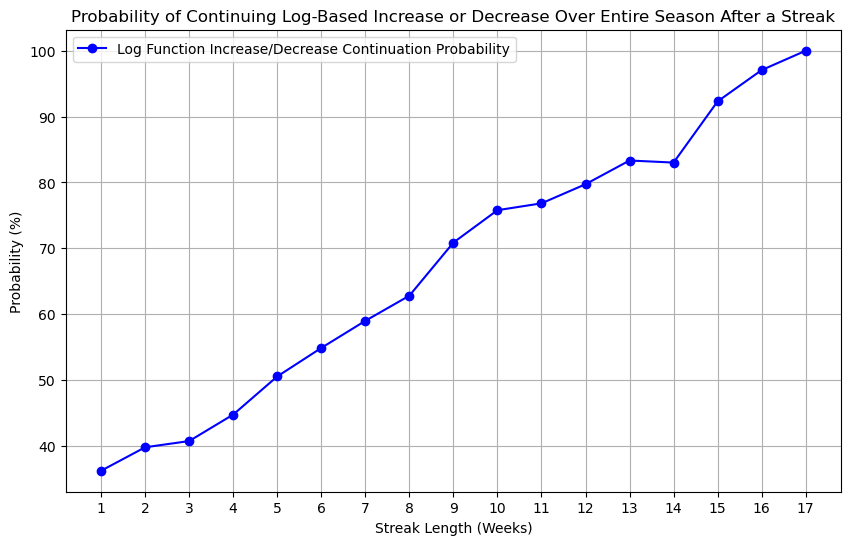

In [41]:
import numpy as np

def log_increase_threshold(avg_points):
    """Applies the log function to calculate the increase threshold."""
    return 6.9 * np.log(avg_points) - .5

def log_decrease_threshold(avg_points):
    """Applies the log function to calculate the decrease threshold (inverse)."""
    return avg_points - (log_increase_threshold(avg_points) - avg_points)

def calculate_combined_streak_probabilities(merged_df, min_weeks=1, max_weeks=17):
    combined_probabilities = []
    
    player_ids = merged_df['player_id'].unique()

    for streak_length in range(min_weeks, max_weeks + 1):
        qualifying_players = 0
        continued_streak_players = 0

        for player_id in player_ids:
            player_data = merged_df[merged_df['player_id'] == player_id].sort_values('week')
            avg_fantasy_points_2022 = player_data['avg_fantasy_points_ppr'].iloc[0]

            player_data['rolling_avg'] = player_data['fantasy_points_ppr'].rolling(window=streak_length).mean()

            increase_threshold = log_increase_threshold(avg_fantasy_points_2022)
            decrease_threshold = log_decrease_threshold(avg_fantasy_points_2022)

            increase_condition = player_data['rolling_avg'] > increase_threshold
            decrease_condition = player_data['rolling_avg'] < decrease_threshold

            if increase_condition.any() or decrease_condition.any():
                qualifying_players += 1

                avg_fantasy_points_2023 = player_data['fantasy_points_ppr'].mean()
                if avg_fantasy_points_2023 > increase_threshold or avg_fantasy_points_2023 < decrease_threshold:
                    continued_streak_players += 1

        probability = (continued_streak_players / qualifying_players) * 100 if qualifying_players > 0 else 0
        combined_probabilities.append(probability)

    return combined_probabilities

combined_probabilities = calculate_combined_streak_probabilities(merged_df)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 18), combined_probabilities, marker='o', color='blue', label='Log Function Increase/Decrease Continuation Probability')

plt.title('Probability of Continuing Log-Based Increase or Decrease Over Entire Season After a Streak')
plt.xlabel('Streak Length (Weeks)')
plt.ylabel('Probability (%)')
plt.grid(True)
plt.xticks(range(1, 18))
plt.legend()

plt.show()


In [44]:
combined_probabilities

[36.235955056179776,
 39.795918367346935,
 40.74074074074074,
 44.761904761904766,
 50.54945054945055,
 54.87804878048781,
 58.992805755395686,
 62.8099173553719,
 70.87378640776699,
 75.78947368421053,
 76.82926829268293,
 79.72972972972973,
 83.33333333333334,
 83.01886792452831,
 92.3076923076923,
 97.05882352941177,
 100.0]

In [49]:
combo_prob_df = pd.DataFrame(combined_probabilities, columns=['Probability'])
combo_prob_df

,Probability
0,36.235955
1,39.795918
2,40.740741
3,44.761905
4,50.549451
5,54.878049
6,58.992806
7,62.809917
8,70.873786
9,75.789474


In [77]:
new_row_names = [f'{i+1} Week' for i in range(len(combined_probabilities))]
combo_prob_df.index = new_row_names
combo_prob_df

,Probability
1 Week,36.235955
2 Week,39.795918
3 Week,40.740741
4 Week,44.761905
5 Week,50.549451
6 Week,54.878049
7 Week,58.992806
8 Week,62.809917
9 Week,70.873786
10 Week,75.789474


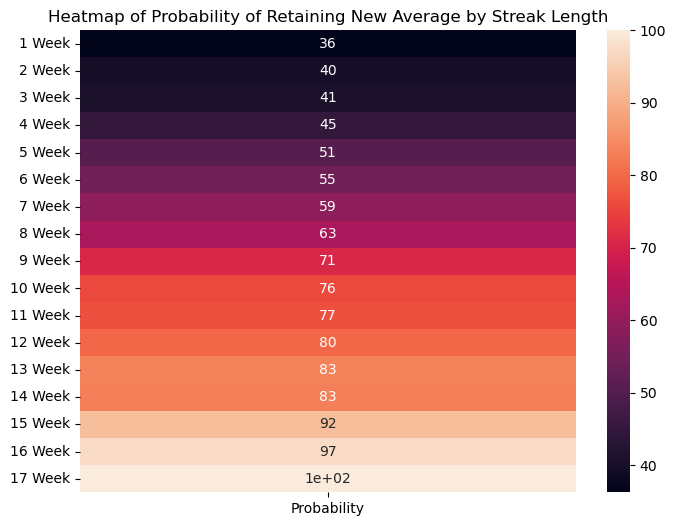

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import dhs_util
from dhs_util import *

plt.figure(figsize=(8, 6))
sns.heatmap(combo_prob_df, annot=True)
plt.title('Heatmap of Probability of Retaining New Average by Streak Length')
plt.show()